In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/CV-crowd-flow-estimation-/notebooks'
!pwd

/content/drive/MyDrive/CV-crowd-flow-estimation-/notebooks
/content/drive/MyDrive/CV-crowd-flow-estimation-/notebooks


In [5]:
import sys
import os
import torch
import matplotlib.pyplot as plt
# Add project root to sys.path (one directory up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data_loader import ShanghaiTechDataModule
from src.train import train_model
from torchvision import transforms
from torchvision.models import get_model

### Resnet Density Map

In [ ]:
#Train

device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) Prepare the data
data_module = ShanghaiTechDataModule(
    data_folder="../data/ShanghaiTech",
    part="part_A",
    validation_split=0.1,
    sigma=5,
    return_count=False,
    batch_size=8,
    num_workers=4,
    density_map_size=(192, 192),
)

# 2) Train the model (15 epochs)
train_model(
    data_module,
    model_name="resnet50",
    epochs=15,
    lr=1e-4,
    #batch_size=8,
    pretrained=True,
    save_path="../models/pth/part_A_resnet50.pth"
)


Using device: cuda
Using CUDA: Tesla T4


[resnet50] Epoch 1/15  Train MSE: 0.003835, MAE: 0.001796  Val   MSE: 0.001141, MAE: 0.001061


[resnet50] Epoch 2/15  Train MSE: 0.000895, MAE: 0.001050  Val   MSE: 0.000902, MAE: 0.001056


Epoch 3/15 [Train]:  62%|██████▏   | 21/34 [00:17<00:10,  1.26it/s]

In [ ]:
# 3) Load the finetuned model for inference
from models.resnet50_backbone import ResNet50Backbone

model = ResNet50Backbone(pretrained=True)
model.load_state_dict(torch.load("../models/pth/part_A_resnet50.pth", map_location=device))
model.to(device).eval()

# 4) Fetch one sample from the test set
test_loader = data_module.test_dataloader()
imgs, gt_maps = next(iter(test_loader))   # imgs: [B,3,H,W], gt_maps: [B,1,H,W]
img, gt_map   = imgs[0], gt_maps[0]       # pick first sample

# 5) Run inference
with torch.no_grad():
    input_img = img.unsqueeze(0).to(device)       # [1,3,H,W]
    pred_map  = model(input_img)                  # [1,1,H,W]
    pred_map  = pred_map.squeeze(0).squeeze(0).cpu().numpy()  # [H,W]

# 6) Plot RGB, ground-truth density, and predicted density
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(img.permute(1, 2, 0).cpu())
axes[0].set_title("Input Image")
axes[0].axis("off")

# Ground-truth density
axes[1].imshow(gt_map.squeeze(0).cpu().numpy(), cmap="jet")
axes[1].set_title("Ground-Truth Density")
axes[1].axis("off")

# Predicted density
axes[2].imshow(pred_map, cmap="jet")
axes[2].set_title("Predicted Density")
axes[2].axis("off")

plt.tight_layout()
plt.show()


### VGG19bn Density map

In [ ]:
#Train

device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) Prepare the data
data_module = ShanghaiTechDataModule(
    data_folder="../data/ShanghaiTech",
    part="part_A",
    validation_split=0.1,
    sigma=5,
    return_count=False,
    batch_size=8,
    num_workers=4,
    density_map_size=(192, 192),
)

# 2) Train the model (15 epochs)
train_model(
    data_module,
    model_name="vgg19_bn",
    epochs=5,
    lr=1e-4,
    #batch_size=8,
    pretrained=True,
    save_path="../models/pth/part_A_vgg19.pth"
)


Using device: cpu


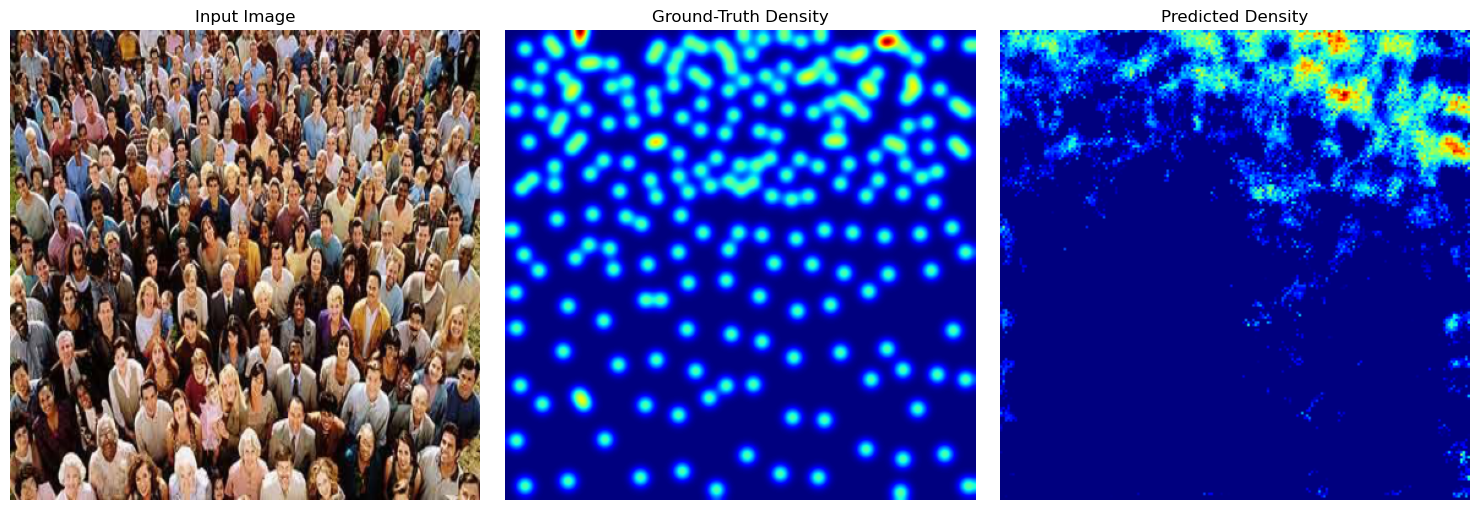

Estimated Count: 181.86 (GT: 223.00)


In [ ]:
# 3) Load the finetuned model for inference
from models.resnet50_backbone import ResNet50Backbone

model = ResNet50Backbone(pretrained=True)
model.load_state_dict(torch.load("../models/pth/part_A_vgg19.pth", map_location=device))
model.to(device).eval()

# 4) Fetch one sample from the test set
test_loader = data_module.test_dataloader()
imgs, gt_maps = next(iter(test_loader))   # imgs: [B,3,H,W], gt_maps: [B,1,H,W]
img, gt_map   = imgs[0], gt_maps[0]       # pick first sample

# 5) Run inference
with torch.no_grad():
    input_img = img.unsqueeze(0).to(device)       # [1,3,H,W]
    pred_map  = model(input_img)                  # [1,1,H,W]
    pred_map  = pred_map.squeeze(0).squeeze(0).cpu().numpy()  # [H,W]

# 6) Plot RGB, ground-truth density, and predicted density
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(img.permute(1, 2, 0).cpu())
axes[0].set_title("Input Image")
axes[0].axis("off")

# Ground-truth density
axes[1].imshow(gt_map.squeeze(0).cpu().numpy(), cmap="jet")
axes[1].set_title("Ground-Truth Density")
axes[1].axis("off")

# Predicted density
axes[2].imshow(pred_map, cmap="jet")
axes[2].set_title("Predicted Density")
axes[2].axis("off")

plt.tight_layout()
plt.show()
